In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, roc_auc_score

import xgboost
from xgboost import XGBClassifier, plot_importance



In [45]:
data = pd.read_csv('Data-Collisions.csv')

C:\Users\ver2bj\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [46]:
# As expected, 37 features, 1 target variable which appears to be binary - suggesting a classification problem. Combination
# of numerical and continuous vs. categorical and discrete variables.

# Take-aways:

# From file saved in C:\Users\ver2bj\Downloads
# - X and Y appear to be coordinates, focused on one particular area
# - ObjectID may suggest what is involved in incident - it's a unique identifier. 
# - Inckey is unique key for incident.  LIKELY UNINSIGHTFUL, SINCE IT"S A CLASSIFIER.
# - Intkey is unique key for intersection where incident happens.  
# - Coldetkey corresponds to collision detail
# - Seglane and Crosswalk have keys reflecting where incident happened
# - Hit Parked Car reflects whether or not this happened
# - Collison code and description given by State Dept of Transportation
# - Whether speeding was factor and whether Pedestrian Right Of Way Was Not Granted
# - Lighting and road conditions
# - Type of Junction, whether or not driver was DUI
# - IN ATTENID - wether collision was due to lack of attention

In [47]:
data.describe() # Analysis below shows diverse range of values for different features. 
# Distance based algorithms may especially benefit from scaling.

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,INTKEY,SEVERITYCODE.1,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,SDOT_COLCODE,SDOTCOLNUM,SEGLANEKEY,CROSSWALKKEY
count,194673.000000,189339.000000,189339.000000,194673.000000,194673.000000,194673.000000,65070.000000,194673.000000,194673.000000,194673.000000,194673.000000,194673.000000,194673.000000,1.149360e+05,194673.000000,1.946730e+05
mean,1.298901,-122.330518,47.619543,108479.364930,141091.456350,141298.811381,37558.450576,1.298901,2.444427,0.037139,0.028391,1.920780,13.867768,7.972521e+06,269.401114,9.782452e+03
std,0.457778,0.029976,0.056157,62649.722558,86634.402737,86986.542110,51745.990273,0.457778,1.345929,0.198150,0.167413,0.631047,6.868755,2.553533e+06,3315.776055,7.226926e+04
min,1.000000,-122.419091,47.495573,1.000000,1001.000000,1001.000000,23807.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.007024e+06,0.000000,0.000000e+00
25%,1.000000,-122.348673,47.575956,54267.000000,70383.000000,70383.000000,28667.000000,1.000000,2.000000,0.000000,0.000000,2.000000,11.000000,6.040015e+06,0.000000,0.000000e+00
50%,1.000000,-122.330224,47.615369,106912.000000,123363.000000,123363.000000,29973.000000,1.000000,2.000000,0.000000,0.000000,2.000000,13.000000,8.023022e+06,0.000000,0.000000e+00
75%,2.000000,-122.311937,47.663664,162272.000000,203319.000000,203459.000000,33973.000000,2.000000,3.000000,0.000000,0.000000,2.000000,14.000000,1.015501e+07,0.000000,0.000000e+00
max,2.000000,-122.238949,47.734142,219547.000000,331454.000000,332954.000000,757580.000000,2.000000,81.000000,6.000000,2.000000,12.000000,69.000000,1.307202e+07,525241.000000,5.239700e+06


In [48]:
# plt.figure(figsize=(20,20))
# sns.heatmap(data.corr(),annot=True)

# Biggest take-away from Seaborn heatmaps: severity code has highest correlation with pedestrian and vehicle count. Makes
# sense - many of the features are categorical

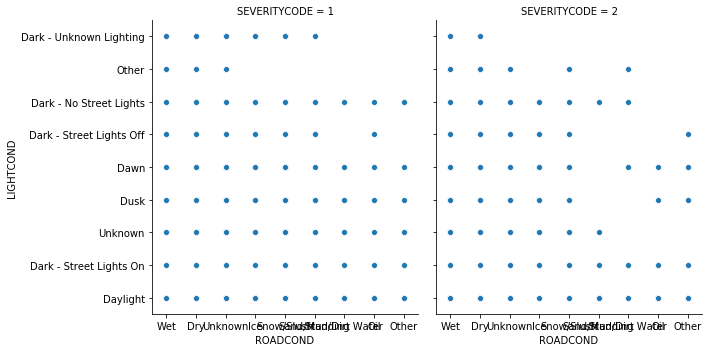

In [49]:
sns.relplot(data=data,x='ROADCOND',y='LIGHTCOND',col='SEVERITYCODE')

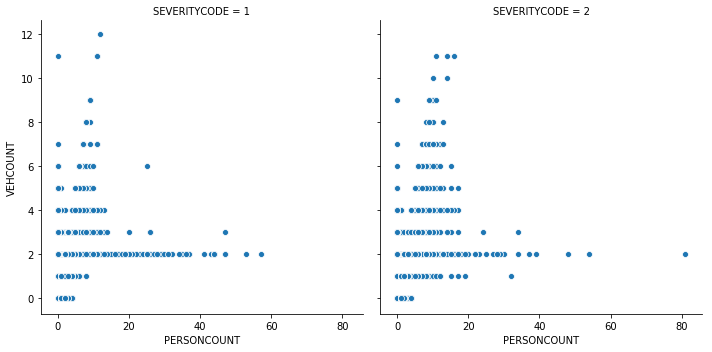

In [50]:
sns.relplot(data=data,x='PERSONCOUNT',y='VEHCOUNT',col='SEVERITYCODE')

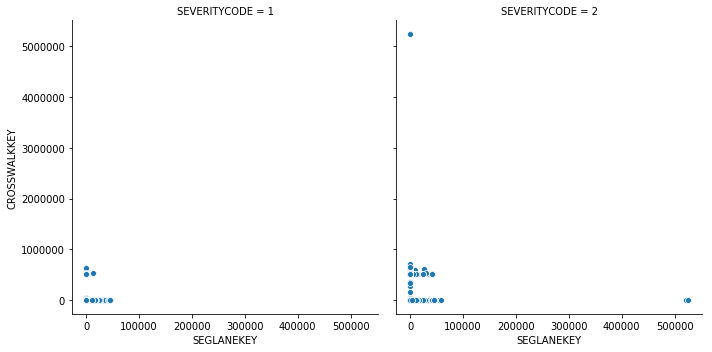

In [51]:
sns.relplot(data=data,x='SEGLANEKEY',y='CROSSWALKKEY',col='SEVERITYCODE')

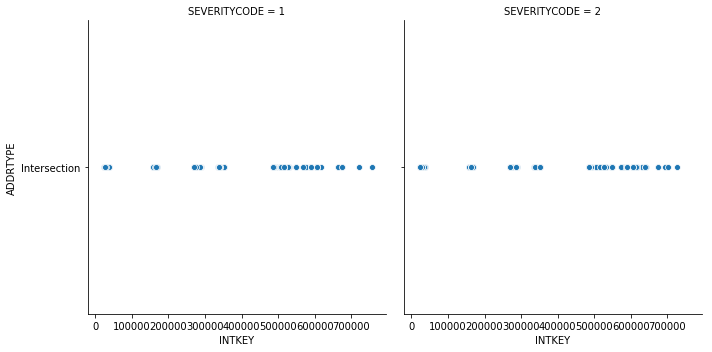

In [52]:
sns.relplot(data=data,x='INTKEY',y='ADDRTYPE',col='SEVERITYCODE')

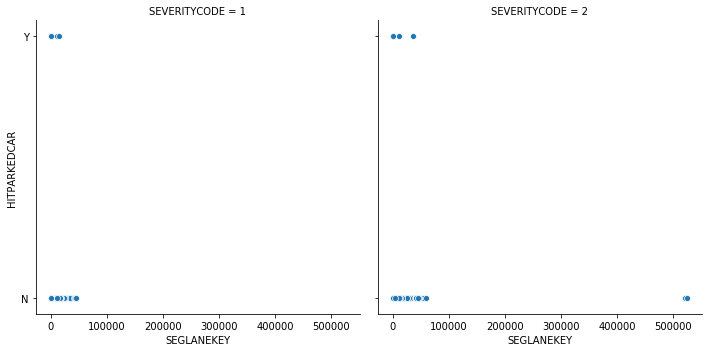

In [53]:
sns.relplot(data=data,x='SEGLANEKEY',y='HITPARKEDCAR',col='SEVERITYCODE')

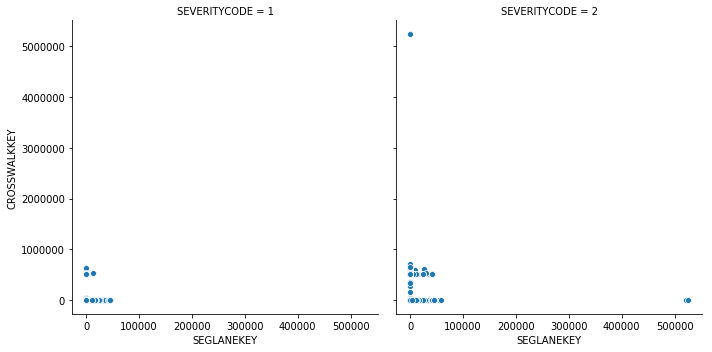

In [54]:
sns.relplot(data=data,x='SEGLANEKEY',y='CROSSWALKKEY',col='SEVERITYCODE')

In [55]:
# Analysis of categorical variables doesn't give insight into any particularly leveraging feature(s). 
# Let's consider distribution of features:

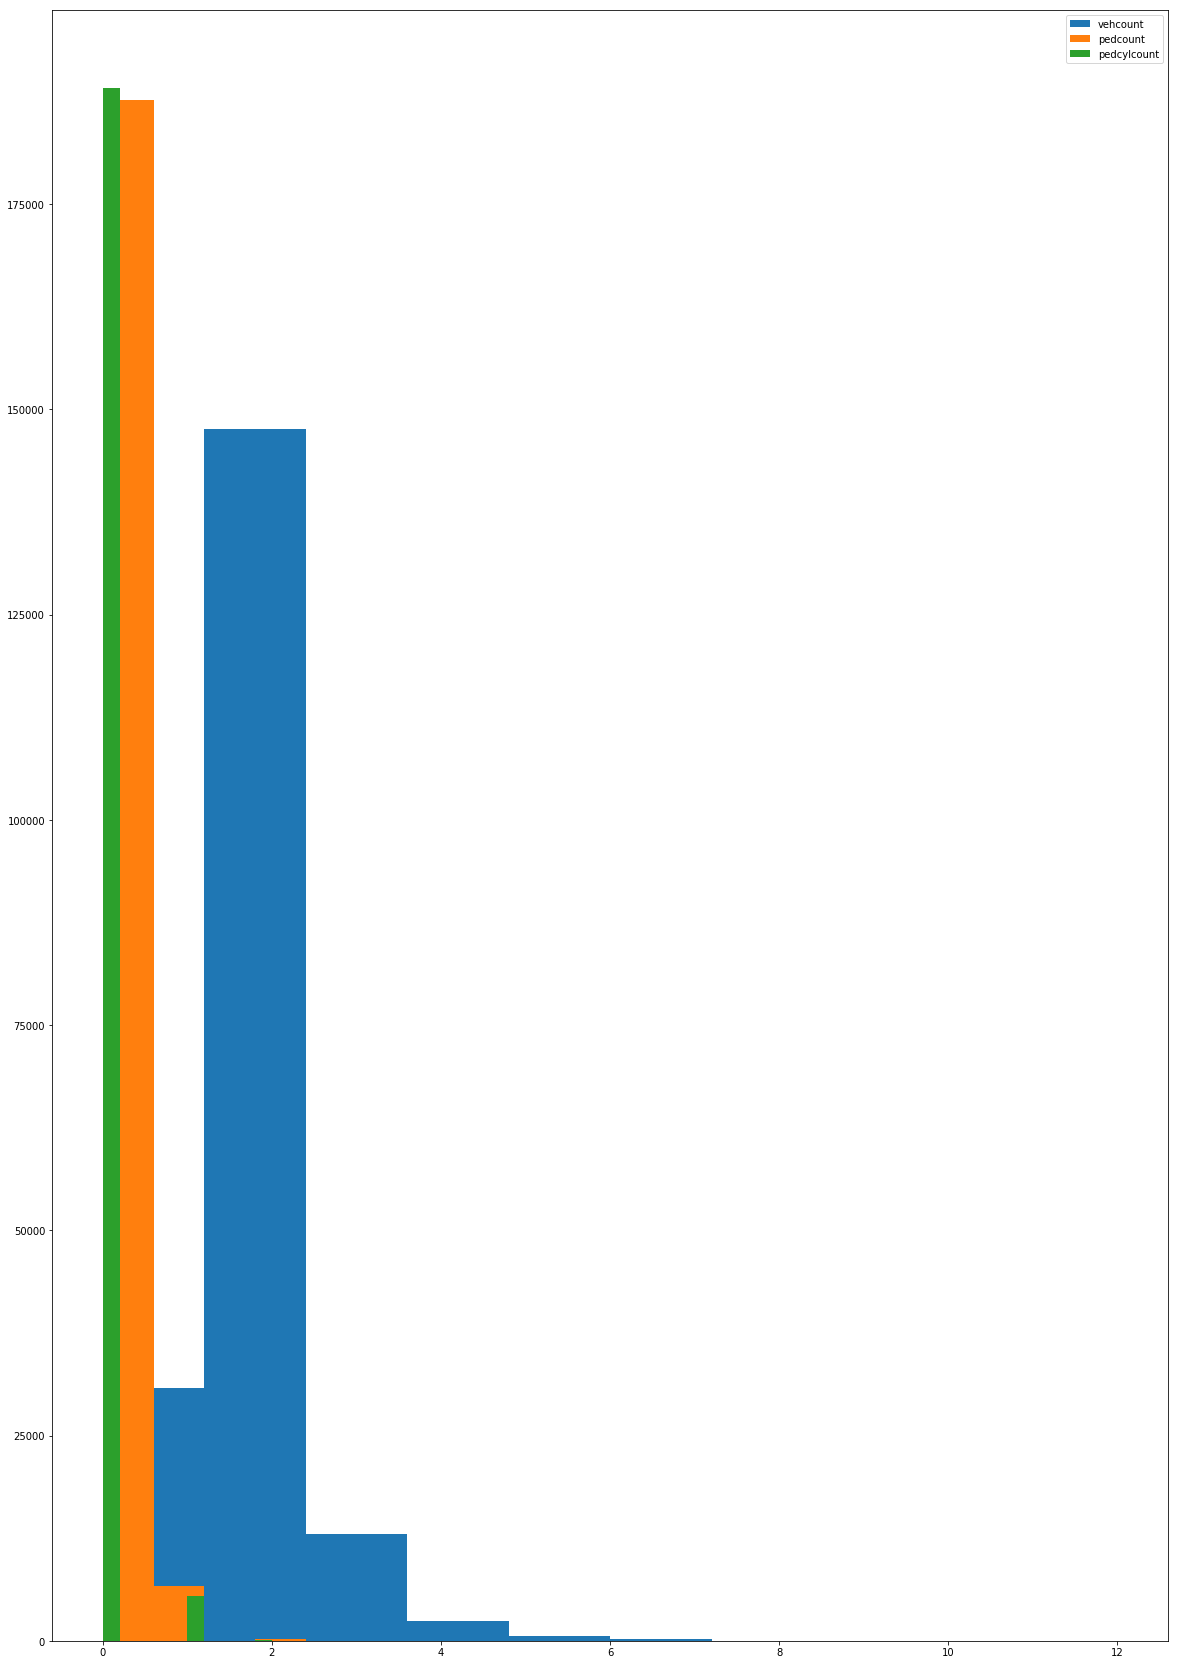

In [56]:
plt.hist(data['VEHCOUNT'],label='vehcount')
plt.hist(data['PEDCOUNT'],label='pedcount')
plt.hist(data['PEDCYLCOUNT'],label='pedcylcount')
plt.legend(loc='upper right')
plt.show()

(array([1.94092e+05, 4.92000e+02, 3.80000e+01, 2.50000e+01, 1.00000e+01,
        1.20000e+01, 2.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 0. ,  8.1, 16.2, 24.3, 32.4, 40.5, 48.6, 56.7, 64.8, 72.9, 81. ]),
 <a list of 10 Patch objects>)

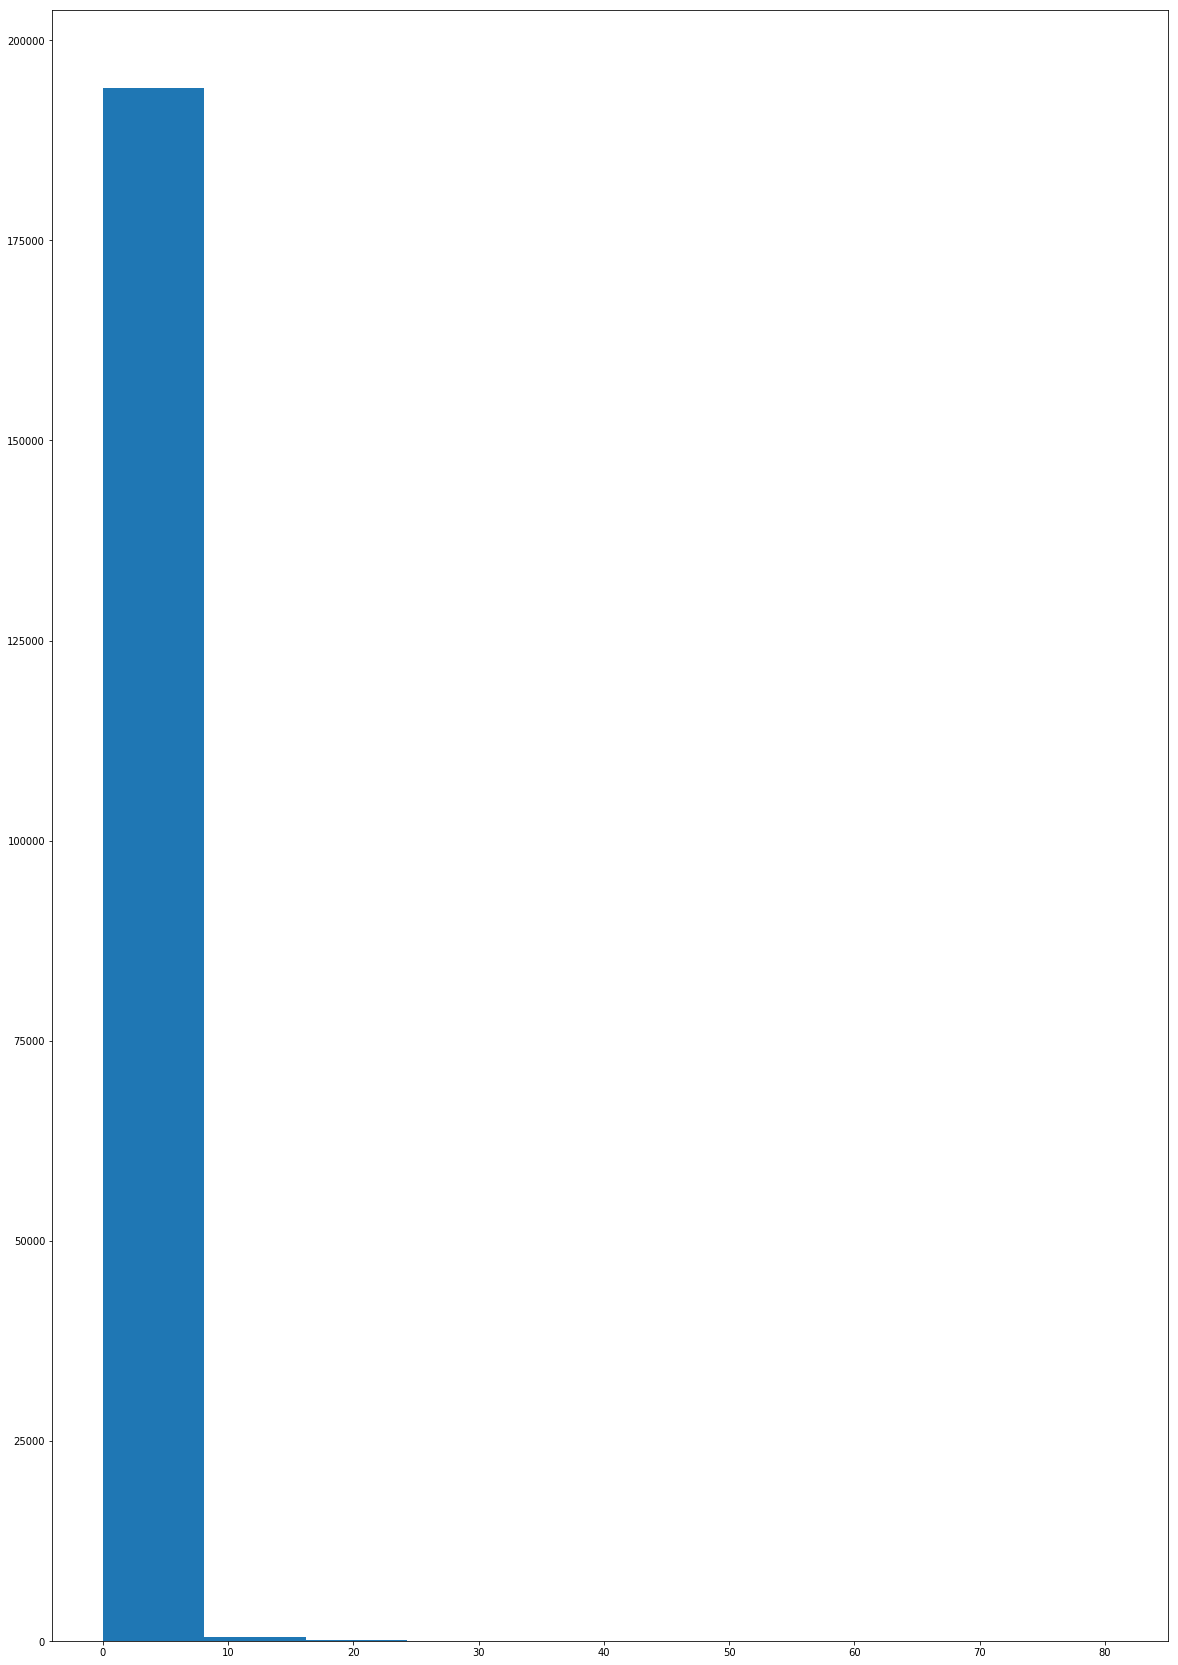

In [57]:
plt.hist(data['PERSONCOUNT'])

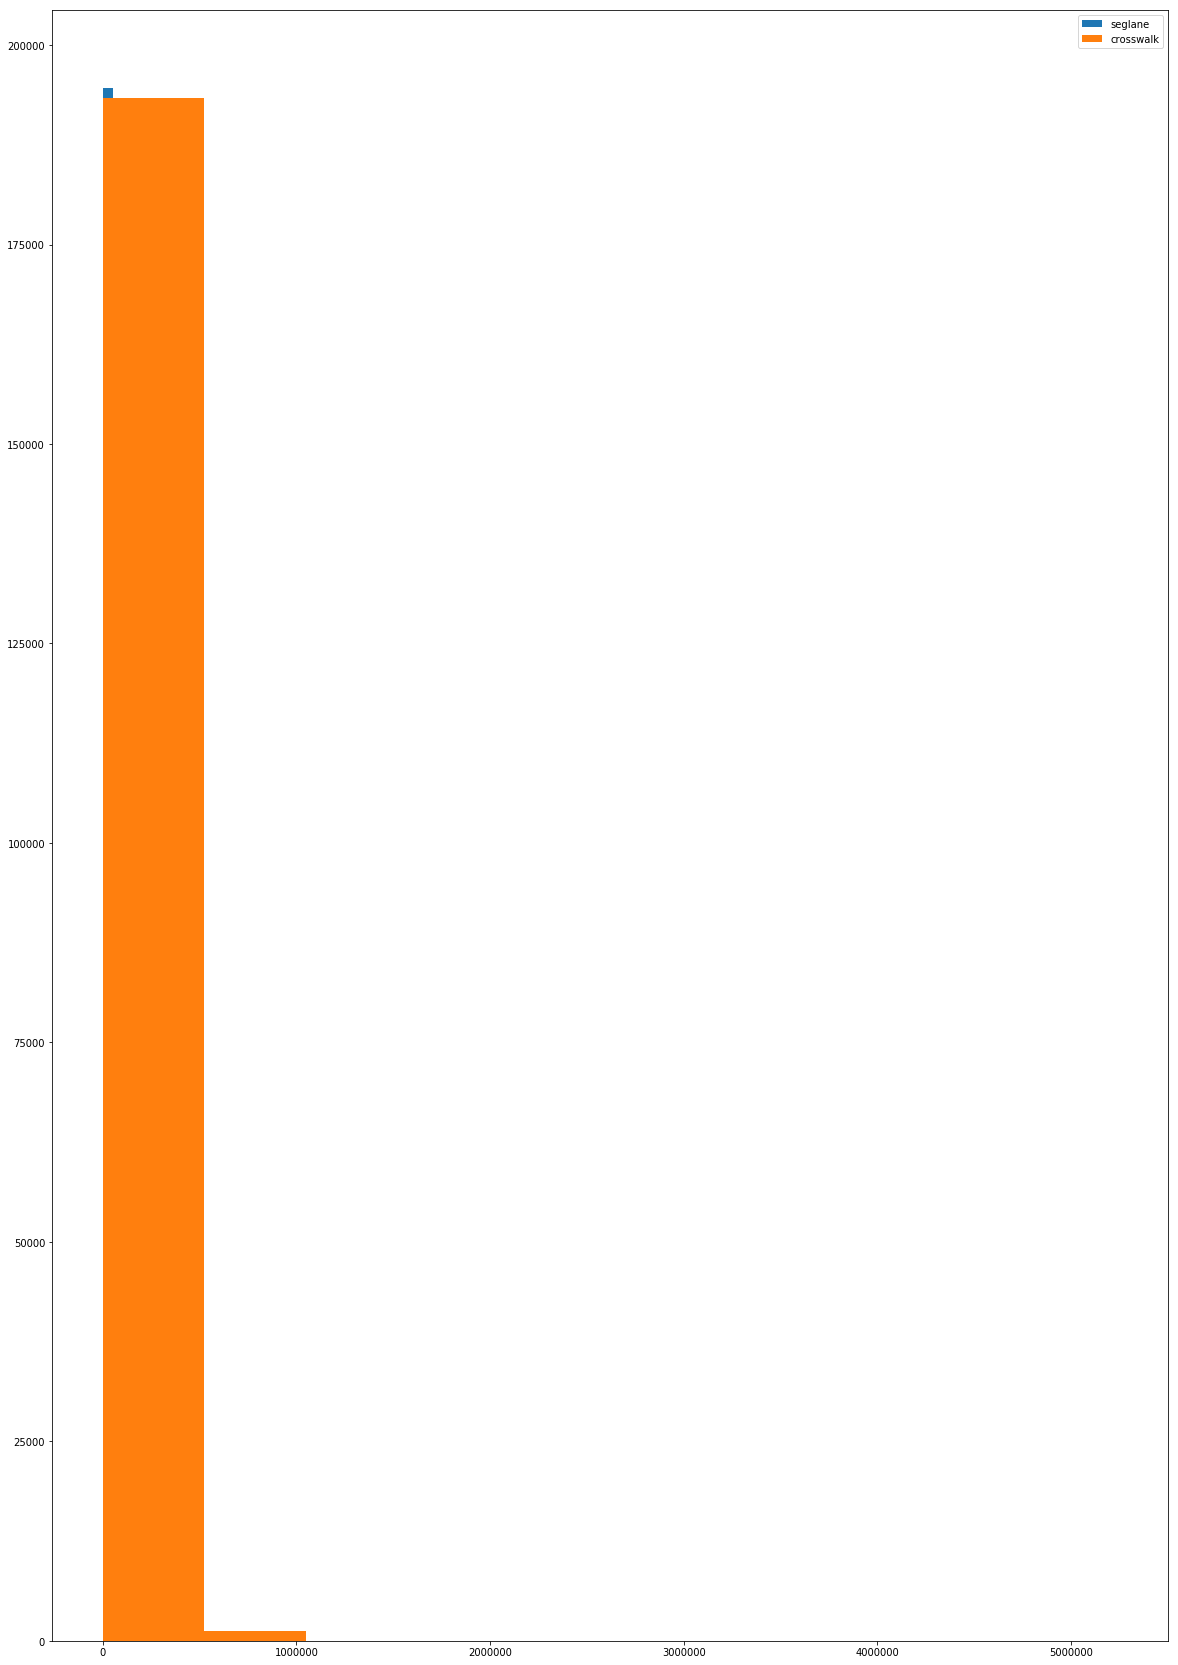

In [58]:
plt.hist(data['SEGLANEKEY'],label='seglane')
plt.hist(data['CROSSWALKKEY'],label='crosswalk')
plt.legend(loc='upper right')
plt.show()

In [59]:
# Categorical data above is highly concentrated, all suggesting specific areas where these incidents happen.
# Lighting and road conditions also don't drive to any immediate conclusions.

In [60]:
data.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [61]:
# Execute following feature engineering and selection steps:

# (1) Remove Report #, location (address only) - DONE
# (2) Remove incKey - DONE
# (3) Remove status - DONE
# (5) One-hot encode ObjectID - DONE
# (6) One-hot encoding of address type - DONE
# (7) Drop intkey - step 6 informs us of intersection - DONE
# (8) Crosswalkkey, seglanekey coldetkey are continuous; leave it in as-is for now - DONE
# (9) I'd think that road and lighting conditions would benefit from ordinal encoding but for now, sticking with one-hot - DONE
# (10) Drop coldesc (DONE) and one-hot encoding of ST_COLCODE - DONE
# (11) One-hot encoding of hit parked car - DONE
# (12) Remove coordinates - DONE
# (13) One-hot encode Collision key, remove Collision Description - DONE
# (14) Delete rows with entries in 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', then remove these columns - DONE
# (15) Remove SeverCode.1, SeverityDesc(for now) - DONE
# (16) One-hot encoding junction type - DONE
# (17) Remove Column - DONE
# (18) Use INCDTTM to extract month --> season in year, and time --> morn,afternoon,evening. Then encode
# (19) One-hot-encoding weather - DONE
# (20) Leave'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT' as-is


In [62]:
data = data[data['EXCEPTRSNCODE']!='NEI']
data.drop(columns=['EXCEPTRSNCODE','EXCEPTRSNDESC'],inplace=True)

x = data.drop(columns='SEVERITYCODE')
y = data['SEVERITYCODE']

x.drop(columns=['REPORTNO','INCKEY','INCDATE','STATUS','ST_COLDESC','LOCATION', 'INTKEY','STATUS','X','Y',
                          'SEVERITYCODE.1', 'SEVERITYDESC', 'SDOTCOLNUM','SDOT_COLDESC','COLDETKEY','OBJECTID','COLLISIONTYPE'],inplace=True)

C:\Users\ver2bj\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [63]:
x['INCDTTM'] = pd.to_datetime(x['INCDTTM'])
x['Month'] = x['INCDTTM'].dt.month
x['TimeOfDay'] = x['INCDTTM'].dt.time
x['TimeOfDay'] = pd.to_datetime(x['INCDTTM'])

In [64]:
x.drop(columns='INCDTTM',inplace=True)

In [65]:
x['TimeOfDay'] = (x['TimeOfDay'].dt.hour % 24 + 4) // 4
x['TimeOfDay'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

In [66]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.4,random_state=42)

x_train = pd.get_dummies(x_train,columns=['ADDRTYPE','ROADCOND','LIGHTCOND','HITPARKEDCAR','JUNCTIONTYPE',
                                          'WEATHER','INATTENTIONIND','UNDERINFL','PEDROWNOTGRNT','SPEEDING','TimeOfDay'])

x_test = pd.get_dummies(x_test,columns=['ADDRTYPE','ROADCOND','LIGHTCOND','HITPARKEDCAR','JUNCTIONTYPE',
                                          'WEATHER','INATTENTIONIND','UNDERINFL','PEDROWNOTGRNT','SPEEDING','TimeOfDay'])

In [67]:
x_train['ST_COLCODE'] = x_train['ST_COLCODE'].replace([np.nan,' '],0)
x_test['ST_COLCODE'] = x_test['ST_COLCODE'].replace([np.nan,' '],0)
x_train['ST_COLCODE'] = x_train['ST_COLCODE'].astype(int) #I have blanks in this code, wich don't permit conversion to int
x_test['ST_COLCODE'] = x_test['ST_COLCODE'].astype(int)

In [68]:
dum = DummyClassifier()
xgb = XGBClassifier()
dt = DecisionTreeClassifier()
gbc = GradientBoostingClassifier()
rfc = RandomForestClassifier()

clfs = [dum,xgb,dt,gbc,rfc]
f1_Scores = []

for clf in clfs:
    clf.fit(x_train,y_train)
    ypred = clf.predict(x_test)
    score = f1_score(ypred,y_test)
    f1_Scores.append(score)

C:\Users\ver2bj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [69]:
f1_Scores

[0.6970375571707816,
 0.8424118143750753,
 0.7933932724176448,
 0.8442339625199092,
 0.8128169205043613]

In [70]:
# xgb_params = {'max_depth': [2, 5],
#               'min_child_weight': [1,3],
#               'learning_rate': [0.09,500]}

# gsXGB = GridSearchCV(xgb, xgb_params, cv = 7, scoring='f1', 
#                      refit=True, n_jobs = 6, verbose=True)
# gsXGB.fit(x_train,y_train)

# XGB_best = gsXGB.best_estimator_

# gsXGB.best_score_

In [71]:
# ypred_xgb_best = XGB_best.predict(x_test)
# xgb_best_score = f1_score(ypred_xgb_best,y_test)
# xgb_best_score

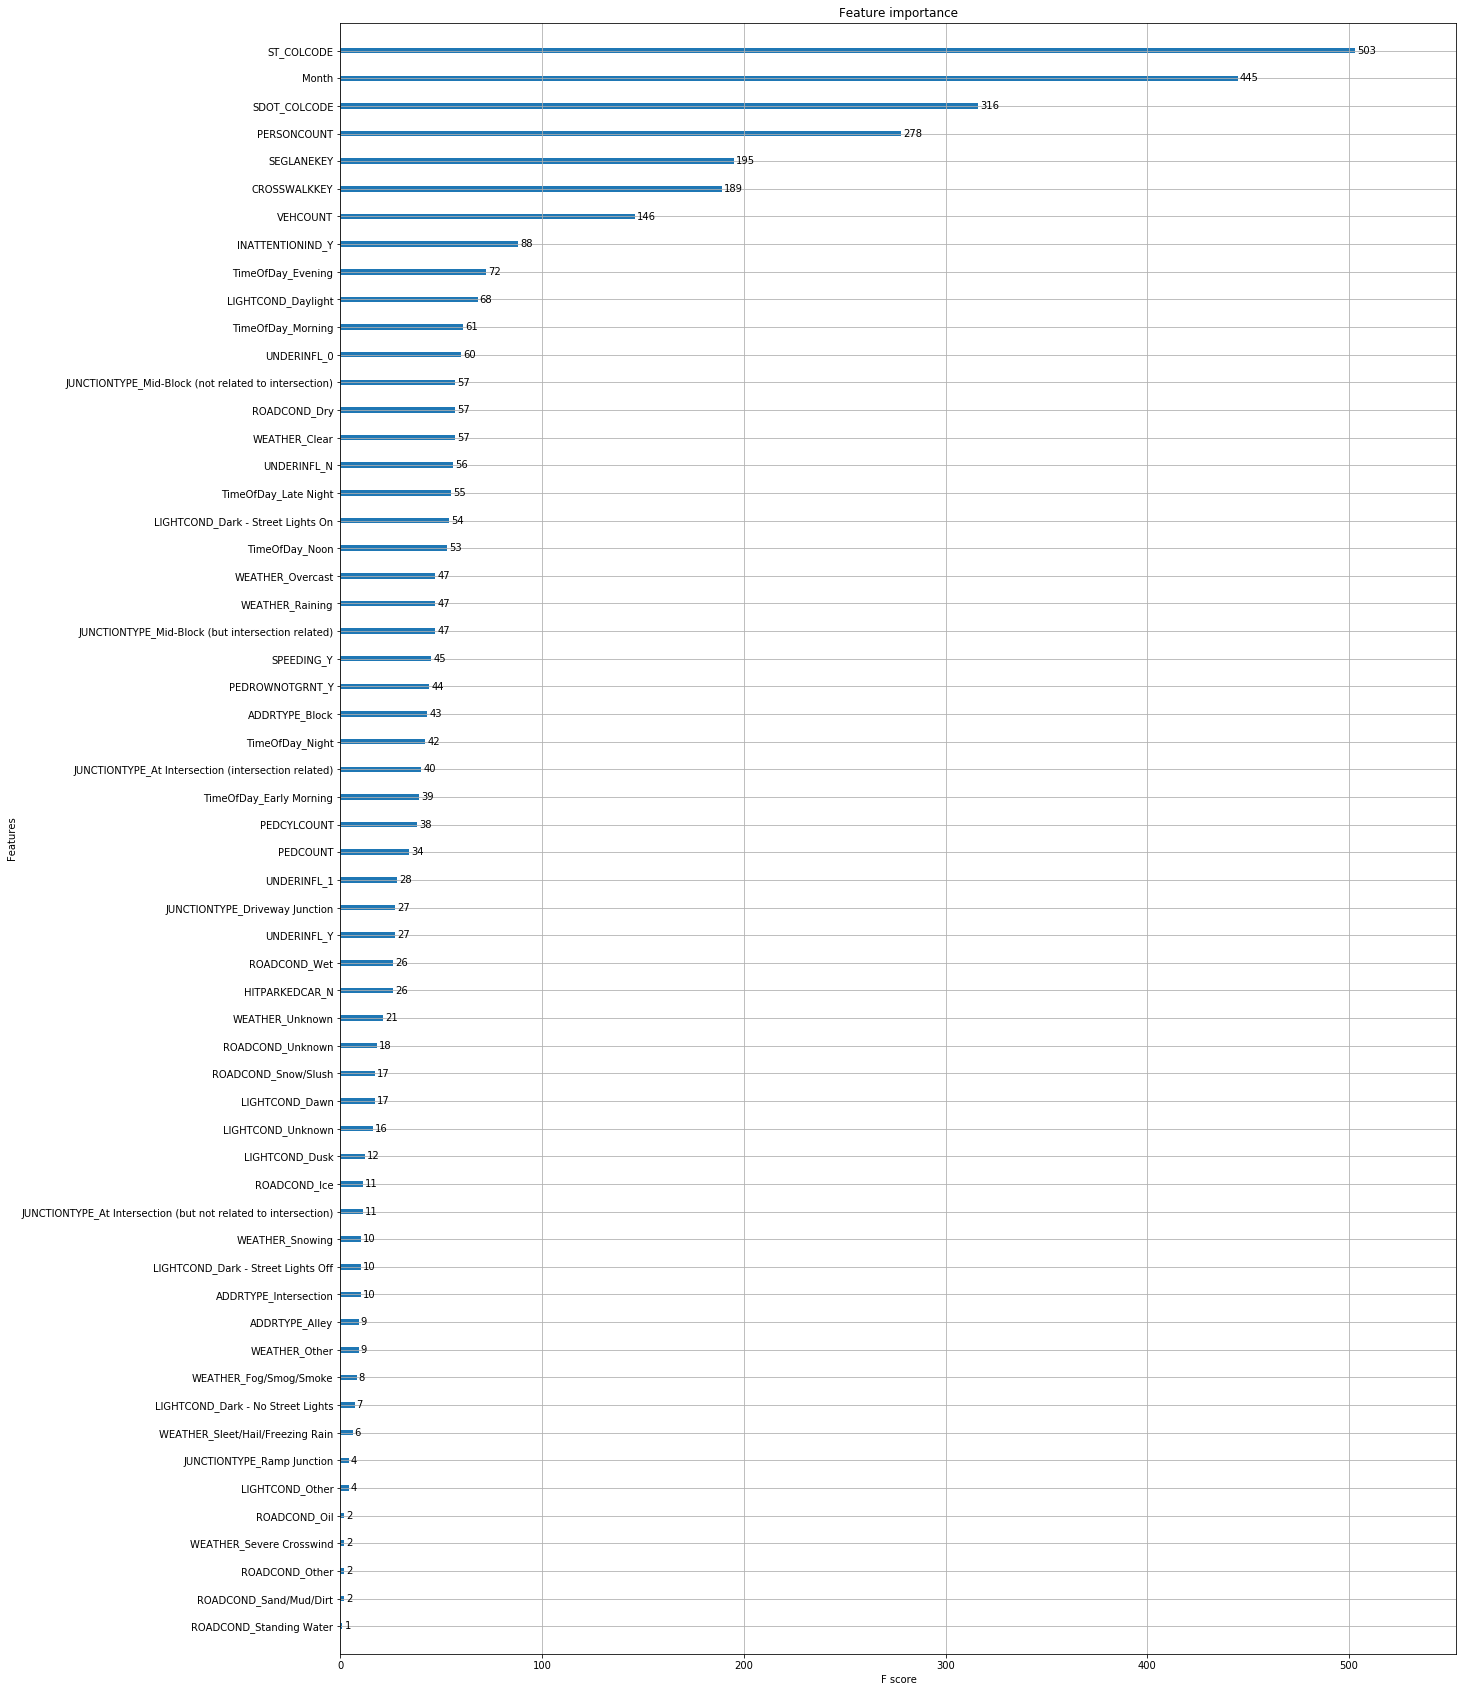

In [72]:
plt.rcParams["figure.figsize"] = (20, 30)
plot_importance(xgb)

In [73]:
text_representation = export_text(dt,feature_names=list(x_train.columns))
print(text_representation)

|--- PEDCOUNT <= 0.50
|   |--- PEDCYLCOUNT <= 0.50
|   |   |--- ST_COLCODE <= 31.50
|   |   |   |--- PERSONCOUNT <= 2.50
|   |   |   |   |--- ADDRTYPE_Intersection <= 0.50
|   |   |   |   |   |--- ST_COLCODE <= 12.50
|   |   |   |   |   |   |--- ST_COLCODE <= 10.50
|   |   |   |   |   |   |   |--- SDOT_COLCODE <= 17.00
|   |   |   |   |   |   |   |   |--- ST_COLCODE <= 5.00
|   |   |   |   |   |   |   |   |   |--- SDOT_COLCODE <= 13.50
|   |   |   |   |   |   |   |   |   |   |--- HITPARKEDCAR_Y <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   |--- HITPARKEDCAR_Y >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |--- SDOT_COLCODE >  13.50
|   |   |   |   |   |   |   |   |   |   |--- SDOT_COLCODE <= 14.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |   |   |   |   |   |--- SDOT_COLCODE >  